# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 308557883_315697185 ***

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

**Visualizing the data**
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:

  1.   For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
  2.   For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:



  1. For the first 1000 data points plot a scatter plot where each class has different color
  2. For all the data points plot a scatter plot where each class has different color




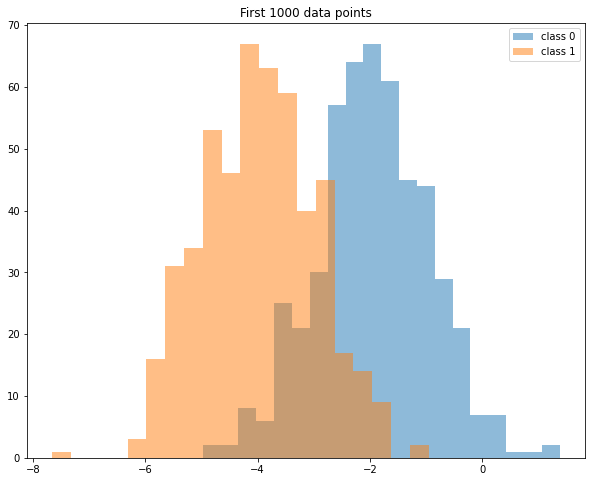

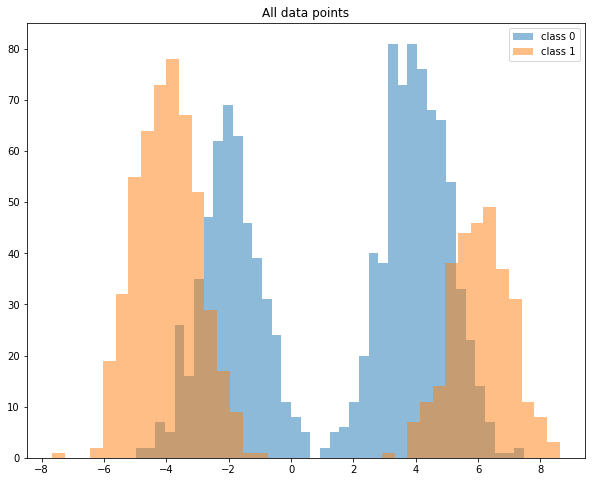

In [4]:
# plotting X1 only
# For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
train_set = np.array(training_set)
train_set_top_1000 = train_set[:1000]
class0_rows = train_set_top_1000[train_set_top_1000[: ,2] == 0][: ,0]
class1_rows = train_set_top_1000[train_set_top_1000[: ,2] == 1][: ,0]

plt.hist(class0_rows, bins = 20, alpha=0.5)
plt.hist(class1_rows, bins=20, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.title("First 1000 data points")
plt.show()

# For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).
train_set = np.array(training_set)
class0_rows = train_set[train_set[: ,2] == 0][: ,0]
class1_rows = train_set[train_set[: ,2] == 1][: ,0]
plt.hist(class0_rows, bins = 40, alpha=0.5)
plt.hist(class1_rows, bins = 40, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.title("All data points")
plt.show()


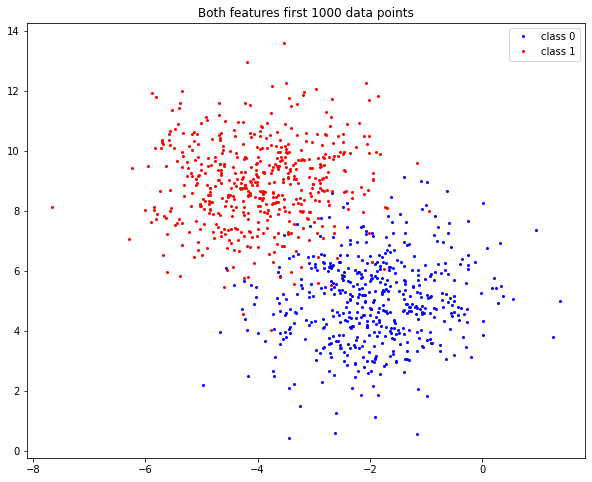

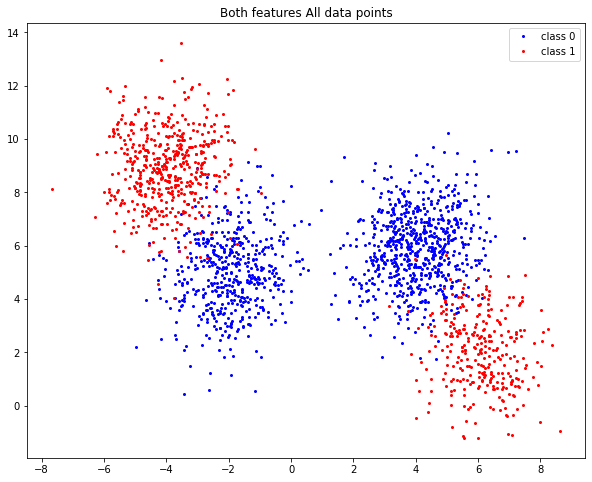

In [5]:
# plotting both features
# For the first 1000 data points plot a scatter plot where each class has different color
class0_rows = train_set_top_1000[train_set_top_1000[: ,2] == 0].T[:2].T
class1_rows = train_set_top_1000[train_set_top_1000[: ,2] == 1].T[:2].T
plt.plot(class0_rows[: ,0], class0_rows[: ,1], 'bo', ms=2)
plt.plot(class1_rows[: ,0], class1_rows[: ,1], 'ro', ms=2)
plt.legend(['class 0', 'class 1'])
plt.title("Both features first 1000 data points")
plt.show()

# For all the data points plot a scatter plot where each class has different color
class0_rows = train_set[train_set[: ,2] == 0].T[:2].T
class1_rows = train_set[train_set[: ,2] == 1].T[:2].T
plt.plot(class0_rows[: ,0], class0_rows[: ,1], 'bo', ms=2)
plt.plot(class1_rows[: ,0], class1_rows[: ,1], 'ro', ms=2)
plt.legend(['class 0', 'class 1'])
plt.title("Both features All data points")
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)})) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)}))
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.cost_history = []
    
    def calc_hypo(self, X):
        return 1 / (1 + np.exp(np.dot(X, -self.theta)))


    def compute_cost(self, X, y):       
        J = 0  # Use J for the cost.
        # evaluates prices of the instances
        h = self.calc_hypo(X)
        calc1 = np.dot(-y, np.log(h))
        calc2 = np.dot((1 - y), np.log(1 - h))
        J = (1/X.shape[0]) * (calc1 - calc2)
        self.cost_history.append(J)
        return J

    def gradient_descent(self, X, y, n_iter):
        prev_cost = self.compute_cost(X, y)
        for i in range(n_iter):
          theta = self.theta.copy() # avoid changing the original thetas
          # evaluates prices of the instances
          h = self.calc_hypo(X)
          diff = h - y
          # iterating through theta 
          self.theta = theta - ((self.eta * np.dot(diff, X)) / X.shape[0])
          # calculating loss value
          cur_cost = self.compute_cost(X, y)
          if prev_cost - cur_cost < self.eps:
            break

          prev_cost = cur_cost

    def bias_trick(self, X):
        """
        performing bias trick on the given data

        Input:
        - X: {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.
        Returns: the data after the bias trick
        """
        X_ones = np.ones((X.shape[0], 1), dtype = int)
        X = np.column_stack((X_ones, X))
        return X

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        X = self.bias_trick(X)
        # generating a random theta vector
        np.random.seed(42)
        self.theta = np.random.random(size= X.shape[1])
        self.gradient_descent(X, y, self.n_iter)
        


    def predict(self, X):
        """Return the predicted class label"""
        X = self.bias_trick(X)
        h = self.calc_hypo(X)
        return np.around(h)
    


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

# shuffling the training data and slice into 4 train folds and 1 validation fold
shuffle_X_train = train_set.copy()
np.random.shuffle(shuffle_X_train)
size = shuffle_X_train.shape[0] // 5

cur_acc = 0
max_acc = 0

# iterating every eta,eps possible pair
for eta in etas:
  for eps in epss:
    cur_acc = 0
    acc_vec = []
    # checking modle accuracy for all the 4 training folds
    for i in range(5):
      # create LOR object with the current eta and eps
      lor = LogisticRegressionGD(eta, 10000, eps, 1)
      shuffle_test = shuffle_X_train[(i * size): ((i + 1) * size)]
      shuffle_train1 = shuffle_X_train[:(i * size)]
      shuffle_train2 = shuffle_X_train[((i + 1) * size):]
      shuffled_data = np.vstack([shuffle_train1, shuffle_train2])
      # train the model with the current pair and fold
      lor.fit(shuffled_data[:, [0,1]], shuffled_data[: ,-1])
      # calculate model accuracy with the validation fold
      acc_vec.append(lor.predict(shuffle_test[:, [0,1]]) == shuffle_test[:, -1])
    
    cur_acc = np.mean(acc_vec)
    # find best pair
    if cur_acc > max_acc:
      max_acc = cur_acc
      best_eta, best_eps = eta, eps

print(f"best eta = {best_eta}")
print(f"best eps = {best_eps}")
print(f"max accuracy = {max_acc * 100}%")


best eta = 0.05
best eps = 1e-06
max accuracy = 79.10000000000001%


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [8]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    coefficient = 1 / (sigma * np.sqrt(2 * np.pi))
    expo = (-0.5) * (((data - mu) / sigma) ** 2)

    return coefficient * np.exp(expo)

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.mu = None
        self.sigma = None
        self.w = None
        self.resp = None
        self.pdf = None

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        # initial mu
        low = np.min(data)
        high = np.max(data)
        self.mu = np.random.uniform(low, high, self.k)

        # initial sigma
        self.sigma = np.asarray([float(1)] * self.k)

        # initial w
        self.w = [1 / self.k] * self.k

        # initial resp
        self.resp = np.zeros(shape = (data.shape[0], self.k))

        # initial pdf
        self.pdf = np.zeros(shape = (data.shape[0], self.k))
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        for x in range(data.shape[0]):
          for k in range(self.k): 
            self.resp[x, k] = self.w[k] * norm_pdf(data[x], self.mu[k], self.sigma[k])
        resp_sum = np.sum(self.resp, axis=1)
        for x in range(self.k):
          self.resp[: ,x] = self.resp[:, x] / resp_sum


    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.w = np.mean(self.resp, axis=0)
        for k in range(self.k):
          self.mu[k] = (1 / (self.w[k] * data.shape[0]))  * np.dot(self.resp[: ,k], data)
          self.sigma[k] =np.sqrt((1 / (self.w[k] * data.shape[0])  * np.dot(self.resp[: ,k], np.square(data - self.mu[k]))))

    def calc_pdf(self, data):
        for k in range(self.k):
          for x in range(data.shape[0]):
            self.pdf[x, k] = norm_pdf(data[x], self.mu[k], self.sigma[k])

    def calc_cost(self, data):
        return np.sum(-np.log(np.dot(self.pdf, self.w)))

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        self.calc_pdf(data)
        # cost with intial params
        prev_cost = self.calc_cost(data)
        
        for i in range(self.n_iter):
          self.expectation(data)
          self.maximization(data) 
          self.calc_pdf(data)
          cur_cost = self.calc_cost(data)
          if prev_cost - cur_cost < self.eps:
            break
          prev_cost = cur_cost

    def get_dist_params(self):
        return self.mu, self.sigma, self.w
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.y = None
        self.EM_params = None 


    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.y = y
        self.EM_params =[[], []] 

        for i in range(X.shape[1]):
          new_EM = EM(self.k)
          new_EM.fit(X[y == 0][:, i])
          mu , sigma, w = new_EM.get_dist_params()
          self.EM_params[0].append([mu, sigma, w])
          new_EM.fit(X[y == 1][:, i])
          mu , sigma, w = new_EM.get_dist_params()
          self.EM_params[1].append([mu, sigma, w])
        
    def get_prior(self, class_value):
        prior = (np.sum(self.y) / self.y.shape[0])
        return (prior if class_value else (1 - prior))

    def get_instance_likelihood(self, x, class_value):
        max_pdf_vec = np.empty((x.shape[0],0))
        # iterating through all features.
        for i in range(x.shape[1]):
            pdf_vec = np.empty((x.shape[0],0))
            # iterating through all gaussian
            for j in range(self.k):
                cur_mu = self.EM_params[class_value][i][0][j]
                cur_sigma = self.EM_params[class_value][i][1][j]
                pdf_vec = np.append(pdf_vec, norm_pdf(x[:, i], cur_mu, cur_sigma)[:, np.newaxis], axis=1)
            max_pdf_vec = np.append(max_pdf_vec, np.max(pdf_vec, axis=1)[:, np.newaxis], axis=1)
        return np.prod(max_pdf_vec, axis=1)

    def get_instance_posterior(self, x, class_val):
        return (self.get_prior(class_val))*(self.get_instance_likelihood(x,class_val))

    def predict(self, X):
        """Return the predicted class label"""
        return (self.get_instance_posterior(X, 0) <= self.get_instance_posterior(X, 1))

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [14]:
testing_set = np.array(test_set)
test_set_top_500 = testing_set[:500]
train_first_1000 = train_set_top_1000[: , [0,1]]
train_first_1000_labels = train_set_top_1000[: , -1]
test_first_500 = test_set_top_500[: , [0,1]]
test_first_500_labels = test_set_top_500[: , -1]

# train models with top 1000 training points
lor_1000 = LogisticRegressionGD(best_eta, 10000, best_eps)
lor_1000.fit(train_first_1000, train_first_1000_labels)

nbg_1000 = NaiveBayesGaussian(2)
nbg_1000.fit(train_first_1000, train_first_1000_labels)

# train models with all training points
lor = LogisticRegressionGD(best_eta, 10000, best_eps)
lor.fit(X_training,y_training)

nbg = NaiveBayesGaussian(2)
nbg.fit(X_training,y_training)


print("------------ Accuracy LogisticRegressionGD ------------")
print(f"Accuracy of 1000 training points: {np.mean(lor_1000.predict(train_first_1000) == train_first_1000_labels) * 100}%")
print(f"Accuracy of 500 test points: {np.mean(lor_1000.predict(test_first_500) == test_first_500_labels) * 100}%")
print(f"Accuracy of all training points: {np.mean(lor.predict(X_training) == y_training) * 100}%")
print(f"Accuracy of all test points : {np.mean(lor.predict(X_test) == y_test) * 100}%")

print('\n')
print("------------ Accuracy NaiveBayesGaussian ------------")
print(f"Accuracy of 1000 training points : {np.mean(nbg_1000.predict(train_first_1000) == train_first_1000_labels) * 100}%")
print(f"Accuracy of 500 test points: {np.mean(nbg_1000.predict(test_first_500) == test_first_500_labels) * 100}%")
print(f"Accuracy of all training points: {np.mean(nbg.predict(X_training) == y_training) * 100}%")
print(f"Accuracy of all test points: {np.mean(nbg.predict(X_test) == y_test) * 100}%")
print('\n')


------------ Accuracy LogisticRegressionGD ------------
Accuracy of 1000 training points: 96.5%
Accuracy of 500 test points: 93.8%
Accuracy of all training points: 79.60000000000001%
Accuracy of all test points : 79.2%


------------ Accuracy NaiveBayesGaussian ------------
Accuracy of 1000 training points : 95.1%
Accuracy of 500 test points: 94.39999999999999%
Accuracy of all training points: 91.2%
Accuracy of all test points: 89.7%




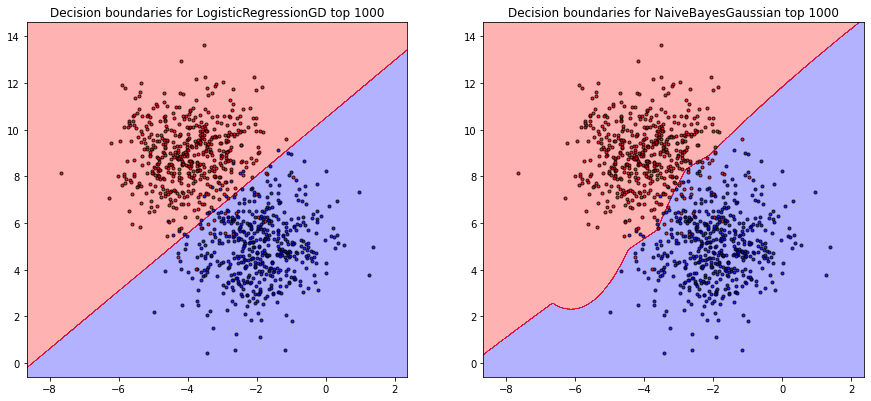

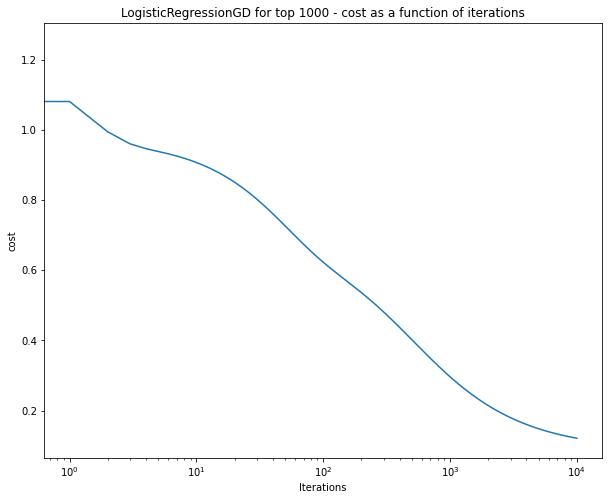

In [12]:
plt.figure(figsize=(15,30))
plt.subplot(4, 2, 1)
plot_decision_regions(train_first_1000, train_first_1000_labels, lor_1000, resolution=0.01)
plt.title("Decision boundaries for LogisticRegressionGD top 1000")

plt.subplot(4, 2, 2)
plot_decision_regions(train_first_1000, train_first_1000_labels, nbg_1000, resolution=0.01)
plt.title("Decision boundaries for NaiveBayesGaussian top 1000")
plt.show()


plt.figure()
plt.plot(np.arange(len(lor_1000.cost_history)), lor_1000.cost_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('cost')
plt.title('LogisticRegressionGD for top 1000 - cost as a function of iterations')
plt.show()


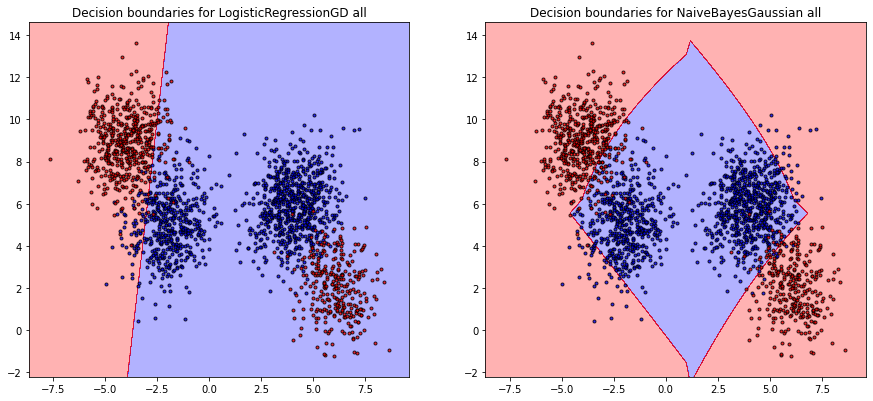

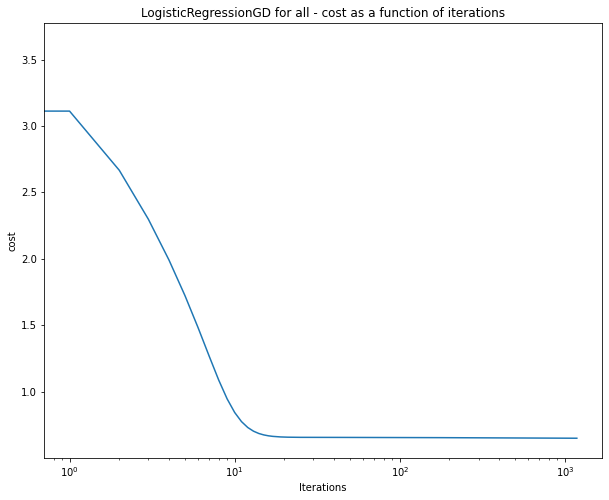

In [13]:
plt.figure(figsize=(15,30))
plt.subplot(4, 2, 1)
plot_decision_regions(X_training, y_training, lor, resolution=0.01)
plt.title("Decision boundaries for LogisticRegressionGD all")

plt.subplot(4, 2, 2)
plot_decision_regions(X_training, y_training, nbg, resolution=0.01)
plt.title("Decision boundaries for NaiveBayesGaussian all")
plt.show()

plt.figure()
plt.plot(np.arange(len(lor.cost_history)), lor.cost_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('cost')
plt.title('LogisticRegressionGD for all - cost as a function of iterations')
plt.show()


##**All features graphes explanation**
**Decision boundaries graphs** 

we can see in both graphs two zones\colored points - Red for class 1 and Blue for class 0. 

- LogisticRegressionGD:
 - Instances located in the Red zone got a probablity greater then 0.5 by the sigmuid function and will be classified as class 1. 
 - Instances located in the Blue zone got a probablity smaller then 0.5 by the sigmuid function and will be classified as class 0

- NaiveBayesGaussian:
  - Instances located in the Red zone got higher posterior with class 1 then  with class 0 and will be classified as class 1
  - Instances located in the Blue zone got higher posterior with class 0 then  with class 1 and will be classified as class 0

**Cost as a function of iterations graph**

We can see that as the number of iterations grows the theta vector improves and thus the cost decreases.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


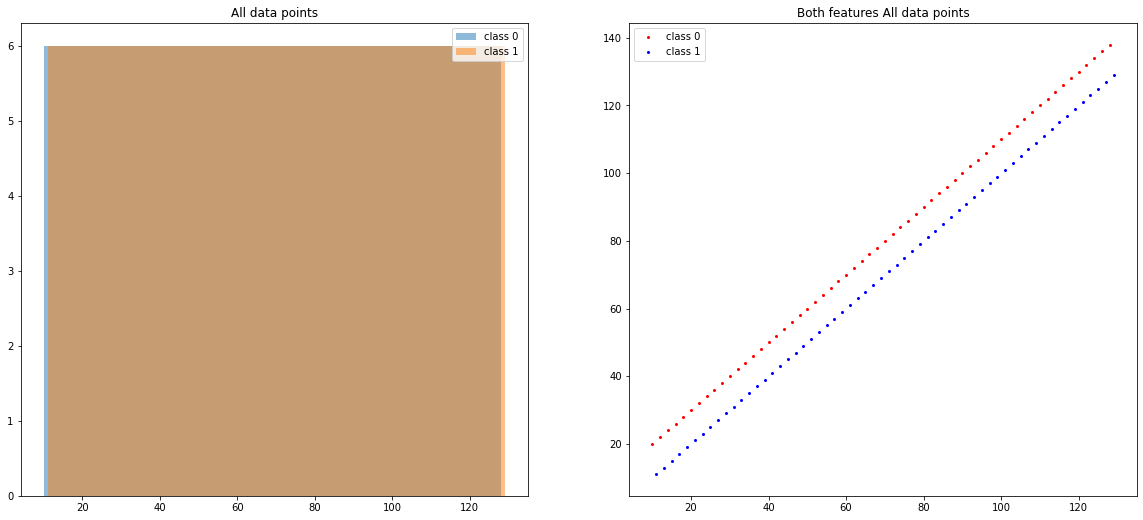

In [15]:
# LOR_dataset - have better accuracy with LogisticRegressionGD
LOR_dataset = []
for i in [10 + i for i in range(120)]:
  if i % 2 == 0:
    LOR_dataset.append([i , i + 10, 0])
  else:
    LOR_dataset.append([i , i , 1])


# For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).
train_set = np.array(LOR_dataset)
plt.figure(figsize=(20,40))
class0_rows = train_set[train_set[: ,2] == 0][: ,0]
class1_rows = train_set[train_set[: ,2] == 1][: ,0]
plt.subplot(4,2,1)
plt.hist(class0_rows, bins = 10, alpha=0.5)
plt.hist(class1_rows, bins = 10, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.title("All data points")


# For all the data points plot a scatter plot where each class has different color
class0_rows = train_set[train_set[: ,2] == 0][: ,[0,1]]
class1_rows = train_set[train_set[: ,2] == 1][: ,[0,1]]
plt.subplot(4,2,2)
plt.plot(class0_rows[: ,0], class0_rows[: ,1], 'ro', ms=2)
plt.plot(class1_rows[: ,0], class1_rows[: ,1], 'bo', ms=2)
plt.legend(['class 0', 'class 1'])
plt.title("Both features All data points")
plt.show()



# **explain - LOR dataset**

- **LOR algorithm** - As we can see in the "Both features all data points" graph, the two classes can be devided by a linear separator, thus the accuracy of the LOR algorithm is very high. 

- **NBG algorithm**- this algorithm assumes that the features are linearly independent (which is not true in this case).Moreover, We can see that in both dimensions (x or y), for each point with value x with classification 0 there exists a point with the same value x with classification 1 (same for y dimension with value y). Given this the gaussians for each class will be similar and will give us a random accuracy (around 50%). 





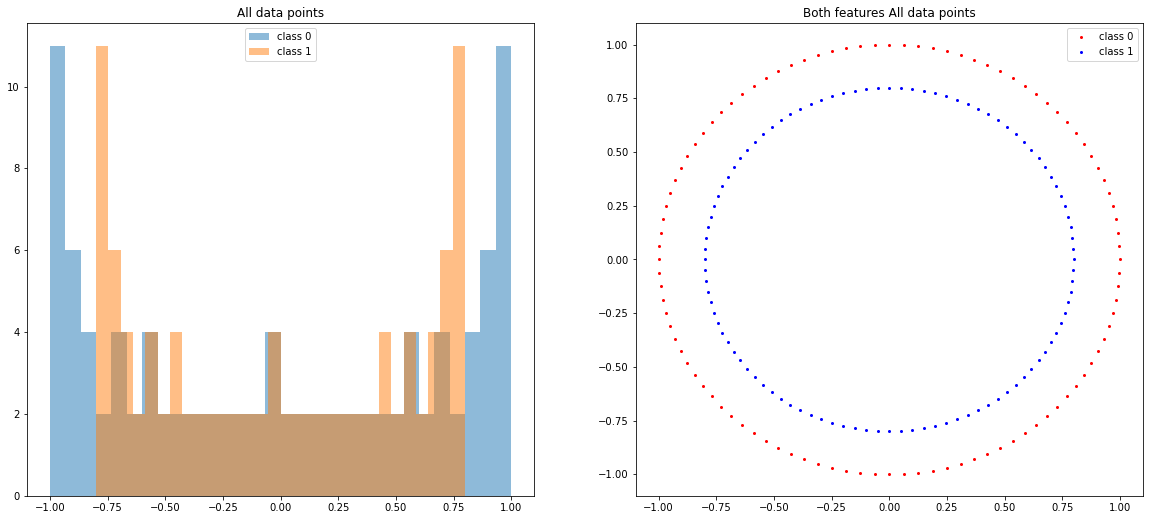

In [16]:
# NGB_dataset - have better accuracy with NaiveBayesGaussian
X,y = make_circles(200)
NGB_dataset = np.column_stack([X, y])

# For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).
train_set = np.array(NGB_dataset)
plt.figure(figsize=(20,40))
class0_rows = train_set[train_set[: ,2] == 0][: ,0]
class1_rows = train_set[train_set[: ,2] == 1][: ,0]
plt.subplot(4,2,1)
plt.hist(class0_rows, bins = 30, alpha=0.5)
plt.hist(class1_rows, bins = 30, alpha=0.5)
plt.legend(['class 0', 'class 1'])
plt.title("All data points")


# For all the data points plot a scatter plot where each class has different color
class0_rows = train_set[train_set[: ,2] == 0][: ,[0,1]]
class1_rows = train_set[train_set[: ,2] == 1][: ,[0,1]]
plt.subplot(4,2,2)
plt.plot(class0_rows[: ,0], class0_rows[: ,1], 'ro', ms=2)
plt.plot(class1_rows[: ,0], class1_rows[: ,1], 'bo', ms=2)
plt.legend(['class 0', 'class 1'])
plt.title("Both features All data points")
plt.show()


# **explain - NaiveBayesGaussian**
- **LOR algorithm** - As we can see in the "Both features all data points" graph the data cant be seperated by a linear separator. Thus, using this algorithm will give us a random accuracy (around 50%).

- **NBG algorithm**- this algorithm assumes that the features are linearly independent (which is true in this case). We can see that in both dimensions (x or y), the gaussians for each class will be different. This will give us a way to predict a point's class - which will be determined by the higher probability that will be calculated by using the gaussians distribution of each class. 
